In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import xgboost as xgb
import numpy as np

In [2]:
datasig=pd.read_csv("sig_many_values.csv")
databkg=pd.read_csv("bkg_many_values.csv")
databkg["label"]=0
datasig["label"]=1

data2=datasig.append(databkg,ignore_index=True)

In [3]:
data2.shape
data2.head()

,jetPt_1,jetEta_1,jetPhi_1,jetE_1,btag_1,jetPt_2,jetEta_2,jetPhi_2,jetE_2,btag_2,...,jetPt_6,jetEta_6,jetPhi_6,jetE_6,btag_6,diPhoPhi,diPhoEta,diPhoPtoM,weight,label
0,179.1340,0.129419,-0.770991,184.053,0.920134,75.2335,-0.047224,-1.281490,76.1059,0.999764,...,37.2568,-0.299217,-1.762450,39.8590,0.032036,1.47030,0.659044,1.629320,0.000071,1
1,161.2780,1.071580,-0.156882,263.612,0.913174,126.8670,0.646219,2.747790,155.3490,0.999908,...,30.6574,1.363930,-0.648138,64.0560,0.032292,-3.10210,1.074770,0.598067,0.000073,1
2,157.1970,-0.333851,0.212655,166.653,0.005083,68.6658,-1.467650,0.122107,157.2250,0.999957,...,50.2075,-0.554880,3.135870,58.4124,0.956340,2.64547,-0.449345,1.746590,0.000053,1
3,143.9920,-0.899087,-0.825905,206.971,0.993589,112.7960,0.119058,0.629660,114.7540,0.132374,...,30.1873,-0.606200,0.356470,36.3707,0.217502,2.49579,-0.719844,2.053300,0.000010,1
4,85.5433,0.699251,-2.586590,108.438,0.999996,74.1270,0.099549,-0.422806,75.8854,0.054680,...,33.7513,-1.301440,2.364960,66.7972,0.059545,2.53021,-1.809120,0.284786,0.000089,1


In [4]:
X,Y=data2.iloc[:,:-2],data2.iloc[:,-1]
weights=data2.iloc[:,-2]
X_train, X_test, y_train, y_test,weight_train,weight_test= train_test_split(X, Y,weights,test_size=0.4, random_state=7)

In [5]:
weight_train=weight_train*10**4
weight_test=weight_test*10**4
weight_train=np.asarray(weight_train)
weight_test=np.asarray(weight_test)
y_test=np.asarray(y_test)
y_train=np.asarray(y_train)
dtest = xgb.DMatrix(data=X_test,weight=weight_test)

In [6]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train,sample_weight=weight_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.37%


In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

AUC: 0.700


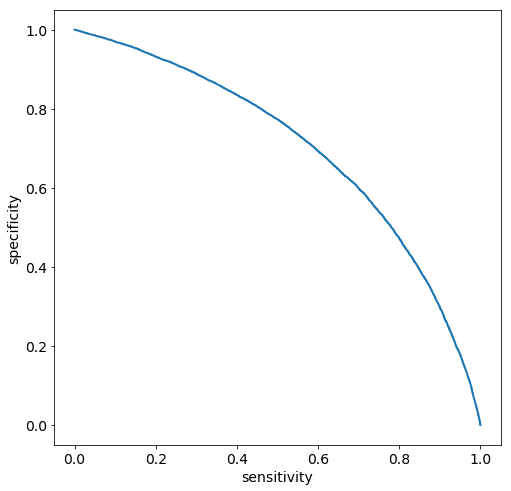

In [8]:
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs,sample_weight=weight_test)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs,sample_weight=weight_test)
# plot the roc curve for the model
plt.figure(figsize=(8,8))
plt.plot(tpr, 1-fpr,linewidth=2)
# show the plot
plt.xlabel("sensitivity",fontsize=14)
plt.ylabel("specificity",fontsize=14)
plt.tick_params(axis="both",labelsize=14)
plt.show()

In [9]:
filename="xgboost_weight.CSV"
with open(filename,"w") as file:
    for kk in range(tpr.size):
        file.write(str(fpr[kk]))
        file.write(" ")
        file.write(str(tpr[kk]))
        file.write("\n")

In [10]:
fpr.size

60526

In [11]:
tpr.size

60526